In [1]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
import missingno as msno
import fancyimpute as fi
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='poster', style='whitegrid', font_scale=1.4)
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel,  wilcoxon, mannwhitneyu
import statsmodels as sm


#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn.mass_univariate import permuted_ols

Using TensorFlow backend.


In [ ]:
!which python

In [2]:
def calculate_pvalues(df, correlation):
    from scipy.stats import pearsonr, pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if correlation == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            if correlation == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            else:
                raise ValueError('Invalid correlation method specified. Accpetable values are \'pearson\' and \'spearman\'.')
    return pvalues

In [3]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def liji_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
#reading in and rearranging data
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'
fig_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/figures'

demo_df = pd.read_csv(join(data_dir, 'c123456_FullDemographics.csv'), encoding='iso-8859-1', 
                      index_col=0, header=0, skipfooter=1, engine='python')
df = pd.read_csv(join(data_dir, 'iq+brain+demo.csv'), index_col=0, header=0)

In [5]:
demo_df.index.shape

(130,)

In [6]:
demo_df[demo_df['Strt.Level'] < 0] = np.nan

demo_df = pd.concat([demo_df, df['Phy48Grade']], axis=1)

In [7]:
post_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_post.txt'), sep='\t', index_col=1)
post_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'Mean Physics Retrieval Accuracy Post'}, axis='columns', inplace=True)
post_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Post',
                      'Mean Incorrect RT': 'Mean Incorrect RT Post'}, axis=1, inplace=True)

pre_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_pre.txt'), sep='\t', index_col=1)
pre_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'Mean Physics Retrieval Accuracy Pre'},axis='columns', inplace=True)
pre_phy_rt_df.drop('Class', axis=1, inplace=True)
pre_phy_rt_df.drop('Gender', axis=1, inplace=True)
pre_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Pre',
                      'Mean Incorrect RT': 'Mean Incorrect RT Pre'}, axis=1, inplace=True)

phy_rt_df = pd.concat((pre_phy_rt_df, post_phy_rt_df), axis=1)

phy_rt_df.drop('index', axis=1, inplace=True)
phy_rt_df.drop('Gender And Class', axis=1, inplace=True)
phy_rt_df.drop('Session', axis=1, inplace=True)
#phy_rt_df.rename({'Mean Correct RT': 'Mean Correct Physics RT',
#                  'Mean Incorrect RT': 'Mean Incorrect Physics RT'}, axis=1, inplace=True)

In [8]:
fci_bx_df = pd.read_csv(join(data_dir, 'fci_accuracy_rt.txt'), sep='\t', index_col=[0,1], header=0)
fci_bx_pre = pd.Series(fci_bx_df.xs('session-0', level='Session')['Mean FCI Accuracy'], name='Pre Mean FCI Accuracy')
fci_bx_post = pd.Series(fci_bx_df.xs('session-1', level='Session')['Mean FCI Accuracy'], name='Post Mean FCI Accuracy')

In [9]:
iq = pd.read_excel('/Users/Katie/Dropbox/Physics Learning/Physics learning_Full Scale IQ.xlsx', index_col=0, header=0)
pre_iq = ['Verbal Comprehension Sum_1', 'Perceptual Reasoning Sum_1',
           'Working Memory Sum_1', 'Processing Speed Sum_1', 'Full Scale IQ_1']
post_iq = ['Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2',
           'Working Memory Sum_2', 'Processing Speed Sum_2', 'Full Scale IQ_2']
iq_vars = pre_iq + post_iq
iqs = ['Perceptual Reasoning Sum', 'Processing Speed Sum', 'Verbal Comprehension Sum', 'Working Memory Sum', 'Full Scale IQ']
drop = set(iq.keys()) - set(iq_vars)
iq.drop(drop, axis=1, inplace=True)

In [10]:
#missing data coded as -9999, replacing with nan
for i in iq.keys():
    iq[iq[i] < 0] = np.nan

In [11]:
subjects = phy_rt_df.index.values

In [12]:
all_df = pd.concat([demo_df, phy_rt_df, fci_bx_pre, fci_bx_post], axis=1)
all_df = pd.concat([all_df, iq], axis=1)
all_df.replace({'Lect': 'Lec'}, inplace=True)

In [13]:
all_df['delta Physics Retrieval Accuracy'] = all_df['Mean Physics Retrieval Accuracy Post'] - all_df['Mean Physics Retrieval Accuracy Pre']
all_df['delta FCI Accuracy'] = all_df['Post Mean FCI Accuracy'] - all_df['Pre Mean FCI Accuracy']
all_df['delta Verbal Comprehension'] = all_df['Verbal Comprehension Sum_2'] - all_df['Verbal Comprehension Sum_1']
all_df['delta Perceptual Reasoning'] = all_df['Perceptual Reasoning Sum_2'] - all_df['Perceptual Reasoning Sum_1']
all_df['delta Working Memory'] = all_df['Working Memory Sum_2'] - all_df['Working Memory Sum_1']
all_df['delta Processing Speed'] = all_df['Processing Speed Sum_2'] - all_df['Processing Speed Sum_1']
all_df['delta Full Scale IQ'] = all_df['Full Scale IQ_2'] - all_df['Full Scale IQ_1']

In [14]:
all_df.drop(['Section', 'Score', 'Test.ID', 'Component',
             'Acad.Plan', 'Study.Cmplt', 'Mean Incorrect RT Pre', 'Mean Incorrect RT Post',
             'Gender', 'Class'], axis=1, inplace=True)

In [15]:
df_f = all_df[all_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = all_df[all_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

# Assessing the shape of the data
Can we use parametric tests? Do we have to switch to nonparametric?

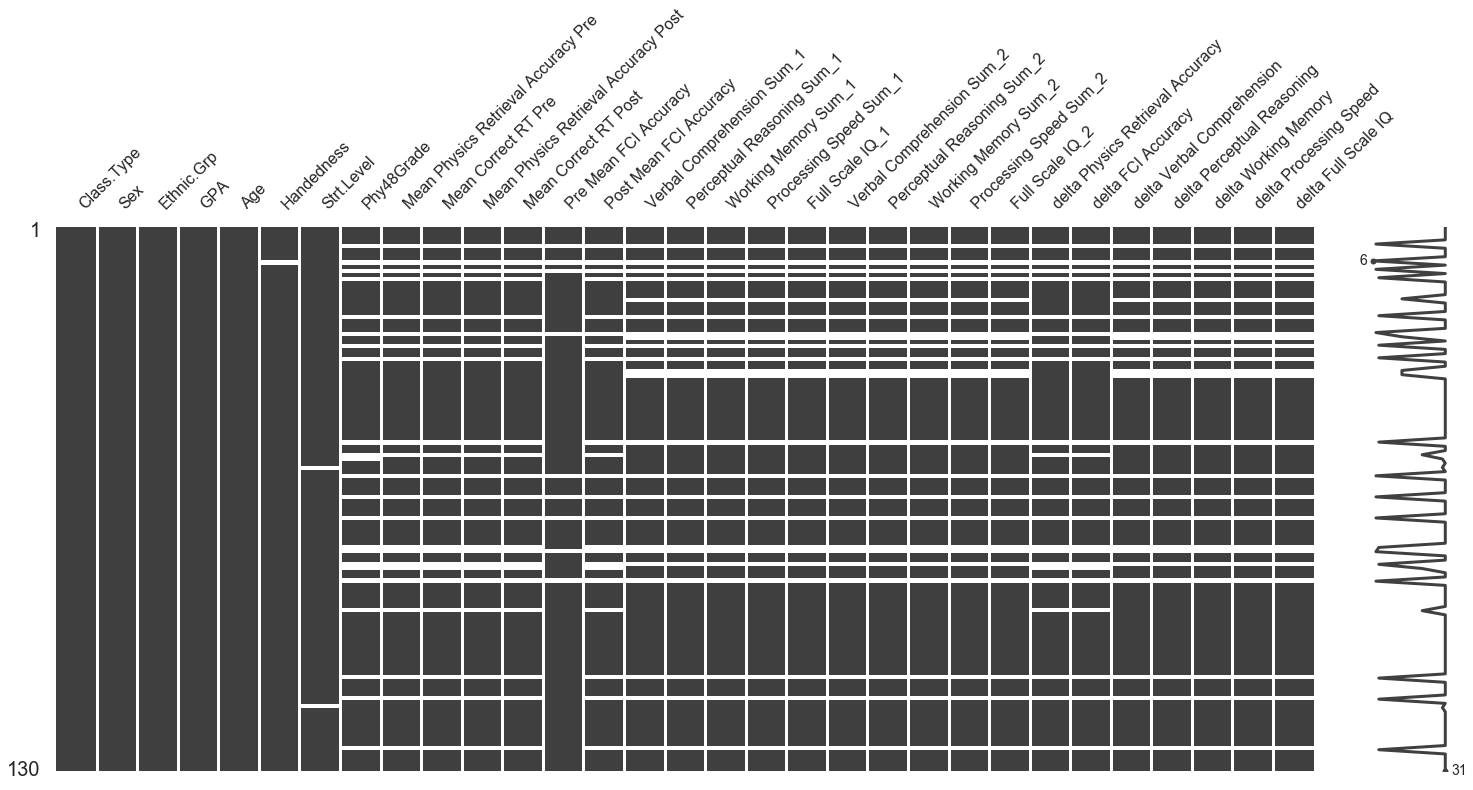

In [16]:
msno.matrix(all_df)

In [17]:
for key in all_df.keys():
    print(key, 1- (all_df[key].dropna().shape[0]/130))

Class.Type 0.0
Sex 0.0
Ethnic.Grp 0.0
GPA 0.0
Age 0.0
Handedness 0.007692307692307665
Strt.Level 0.01538461538461533
Phy48Grade 0.17692307692307696
Mean Physics Retrieval Accuracy Pre 0.16923076923076918
Mean Correct RT Pre 0.16923076923076918
Mean Physics Retrieval Accuracy Post 0.16923076923076918
Mean Correct RT Post 0.16923076923076918
Pre Mean FCI Accuracy 0.0692307692307692
Post Mean FCI Accuracy 0.16923076923076918
Verbal Comprehension Sum_1 0.17692307692307696
Perceptual Reasoning Sum_1 0.17692307692307696
Working Memory Sum_1 0.17692307692307696
Processing Speed Sum_1 0.17692307692307696
Full Scale IQ_1 0.17692307692307696
Verbal Comprehension Sum_2 0.17692307692307696
Perceptual Reasoning Sum_2 0.17692307692307696
Working Memory Sum_2 0.17692307692307696
Processing Speed Sum_2 0.17692307692307696
Full Scale IQ_2 0.17692307692307696
delta Physics Retrieval Accuracy 0.16923076923076918
delta FCI Accuracy 0.16923076923076918
delta Verbal Comprehension 0.17692307692307696
delta P

In [18]:
missing_df = pd.DataFrame(columns=all_df.keys(), index=all_df.index)

for key in missing_df.keys():
    missing_df[key] = all_df[key].isnull()

missing_df.replace({False: 0, True:1}, inplace=True)

for key1 in missing_df.keys():
    try:
        corr,pval = pearsonr(missing_df[key1], all_df[key1])
        if pval < 0.05:
            print(key1, corr, pval)
    except:
        pass
    for key2 in all_df.keys():
        try:
            corr,pval = pearsonr(missing_df[key1], all_df[key2])
            if pval < 0.05:
                print(key1, key2, corr, pval)
        except Exception as e:
            pass

Strt.Level Age -0.5788577495018394 5.443947292273025e-13


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [19]:
impute_pls = fi.KNN(verbose=False)

all_imputed = impute_pls.fit_transform(all_df.drop(['Class.Type', 'Sex', 'Ethnic.Grp'], axis=1))

In [20]:
imputed_df = pd.DataFrame(all_imputed, 
                          columns=all_df.drop(['Class.Type', 'Sex', 'Ethnic.Grp'], axis=1).columns, 
                          index=all_df.index)

In [21]:
imputed_df['Sex'] = all_df['Sex']
imputed_df['Ethnic.Grp'] = all_df['Ethnic.Grp']
imputed_df['Class.Type'] = all_df['Class.Type']

In [22]:
imputed_df[pre_iq]

Verbal Comprehension Sum_1  Perceptual Reasoning Sum_1  \
101                   31.000000                   20.000000   
102                   40.000000                   26.000000   
103                   45.000000                   26.000000   
104                   30.000000                   40.000000   
105                   30.020976                   35.945125   
106                   32.000000                   39.000000   
107                   44.000000                   28.000000   
108                   34.000000                   39.000000   
109                   29.470721                   32.925828   
110                   40.000000                   36.000000   
211                   35.150013                   33.260026   
212                   43.000000                   33.000000   
213                   37.520698                   30.963669   
214                   33.000000                   24.000000   
215                   49.000000                   33.000000   
216                   36.000000                   31.000000   
217                   40.000000                   32.000000   
218                   32.283769                   34.372360   
219                   35.000000                   33.000000   
320                   35.000000                   30.000000   
321                   33.000000                   31.000000   
322                   28.355998                   28.441689   
323                   30.000000                   24.000000   
324                   26.000000                   27.000000   
325                   36.000000                   32.000000   
326                   26.113730                   32.475500   
327                   31.108997                   34.939273   
328                   45.000000                   35.000000   
329                   27.429391                   28.428830   
330                   43.000000                   35.000000   
..                          ...                         ...   
604                   20.000000                   35.000000   
605                   28.000000                   34.000000   
606                   28.000000                   33.000000   
607                   41.000000                   38.000000   
608                   38.000000                   42.000000   
609                   33.000000                   39.000000   
610                   33.000000                   27.000000   
611                   32.201463                   37.809518   
612                   31.000000                   24.000000   
613                   31.000000                   45.000000   
614                   39.000000                   43.000000   
615                   30.000000                   35.000000   
616                   33.897424                   32.502577   
617                   36.000000                   36.000000   
618                   19.000000                   25.000000   
619                   39.000000                   27.000000   
620                   37.000000                   36.000000   
621                   39.000000                   43.000000   
622                   32.000000                   39.000000   
623                   24.000000                   37.000000   
624                   17.000000                   41.000000   
625                   31.000000                   34.000000   
626                   27.000000                   35.000000   
627                   41.000000                   37.000000   
628                   32.945428                   28.495163   
629                   42.000000                   39.000000   
630                   27.000000                   36.000000   
631                   26.000000                   33.000000   
633                   31.000000                   37.000000   
634                   26.000000                   41.000000   

     Working Memory Sum_1  Processing Speed Sum_1  Full Scale IQ_1  
101             20.000000    

In [23]:
df_f = imputed_df[imputed_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = imputed_df[imputed_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

df_f['const'] = 1
df_m['const'] = 1

In [24]:
kurtosis = imputed_df.kurtosis(axis=0, skipna=True)
mean = imputed_df.mean(axis=0, skipna=True)
skew = imputed_df.skew(axis=0, skipna=True)
median = imputed_df.median(axis=0, skipna=True)
stdev = imputed_df.std(axis=0, skipna=True)
descriptives = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives.to_csv('{0}/imputed_descriptives.csv'.format(data_dir), sep=',')

In [25]:
kurtosis = df_f.kurtosis(axis=0, skipna=True)
mean = df_f.mean(axis=0, skipna=True)
skew = df_f.skew(axis=0, skipna=True)
median = df_f.median(axis=0, skipna=True)
stdev = df_f.std(axis=0, skipna=True)
descriptives = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives.to_csv('{0}/imputed_descriptives_f.csv'.format(data_dir), sep=',')

kurtosis = df_m.kurtosis(axis=0, skipna=True)
mean = df_m.mean(axis=0, skipna=True)
skew = df_m.skew(axis=0, skipna=True)
median = df_m.median(axis=0, skipna=True)
stdev = df_m.std(axis=0, skipna=True)
descriptives = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives.to_csv('{0}/imputed_descriptives_m.csv'.format(data_dir), sep=',')

In [26]:
short_iqs = ['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ']

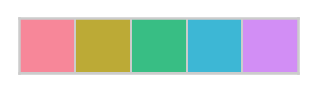

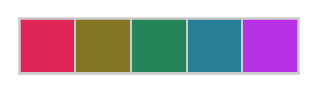

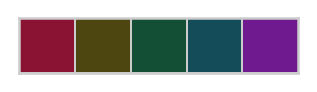

In [27]:
light_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.7)
dark_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.5)
darker_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.3)
sns.palplot(light_hsl)
sns.palplot(dark_hsl)
sns.palplot(darker_hsl)

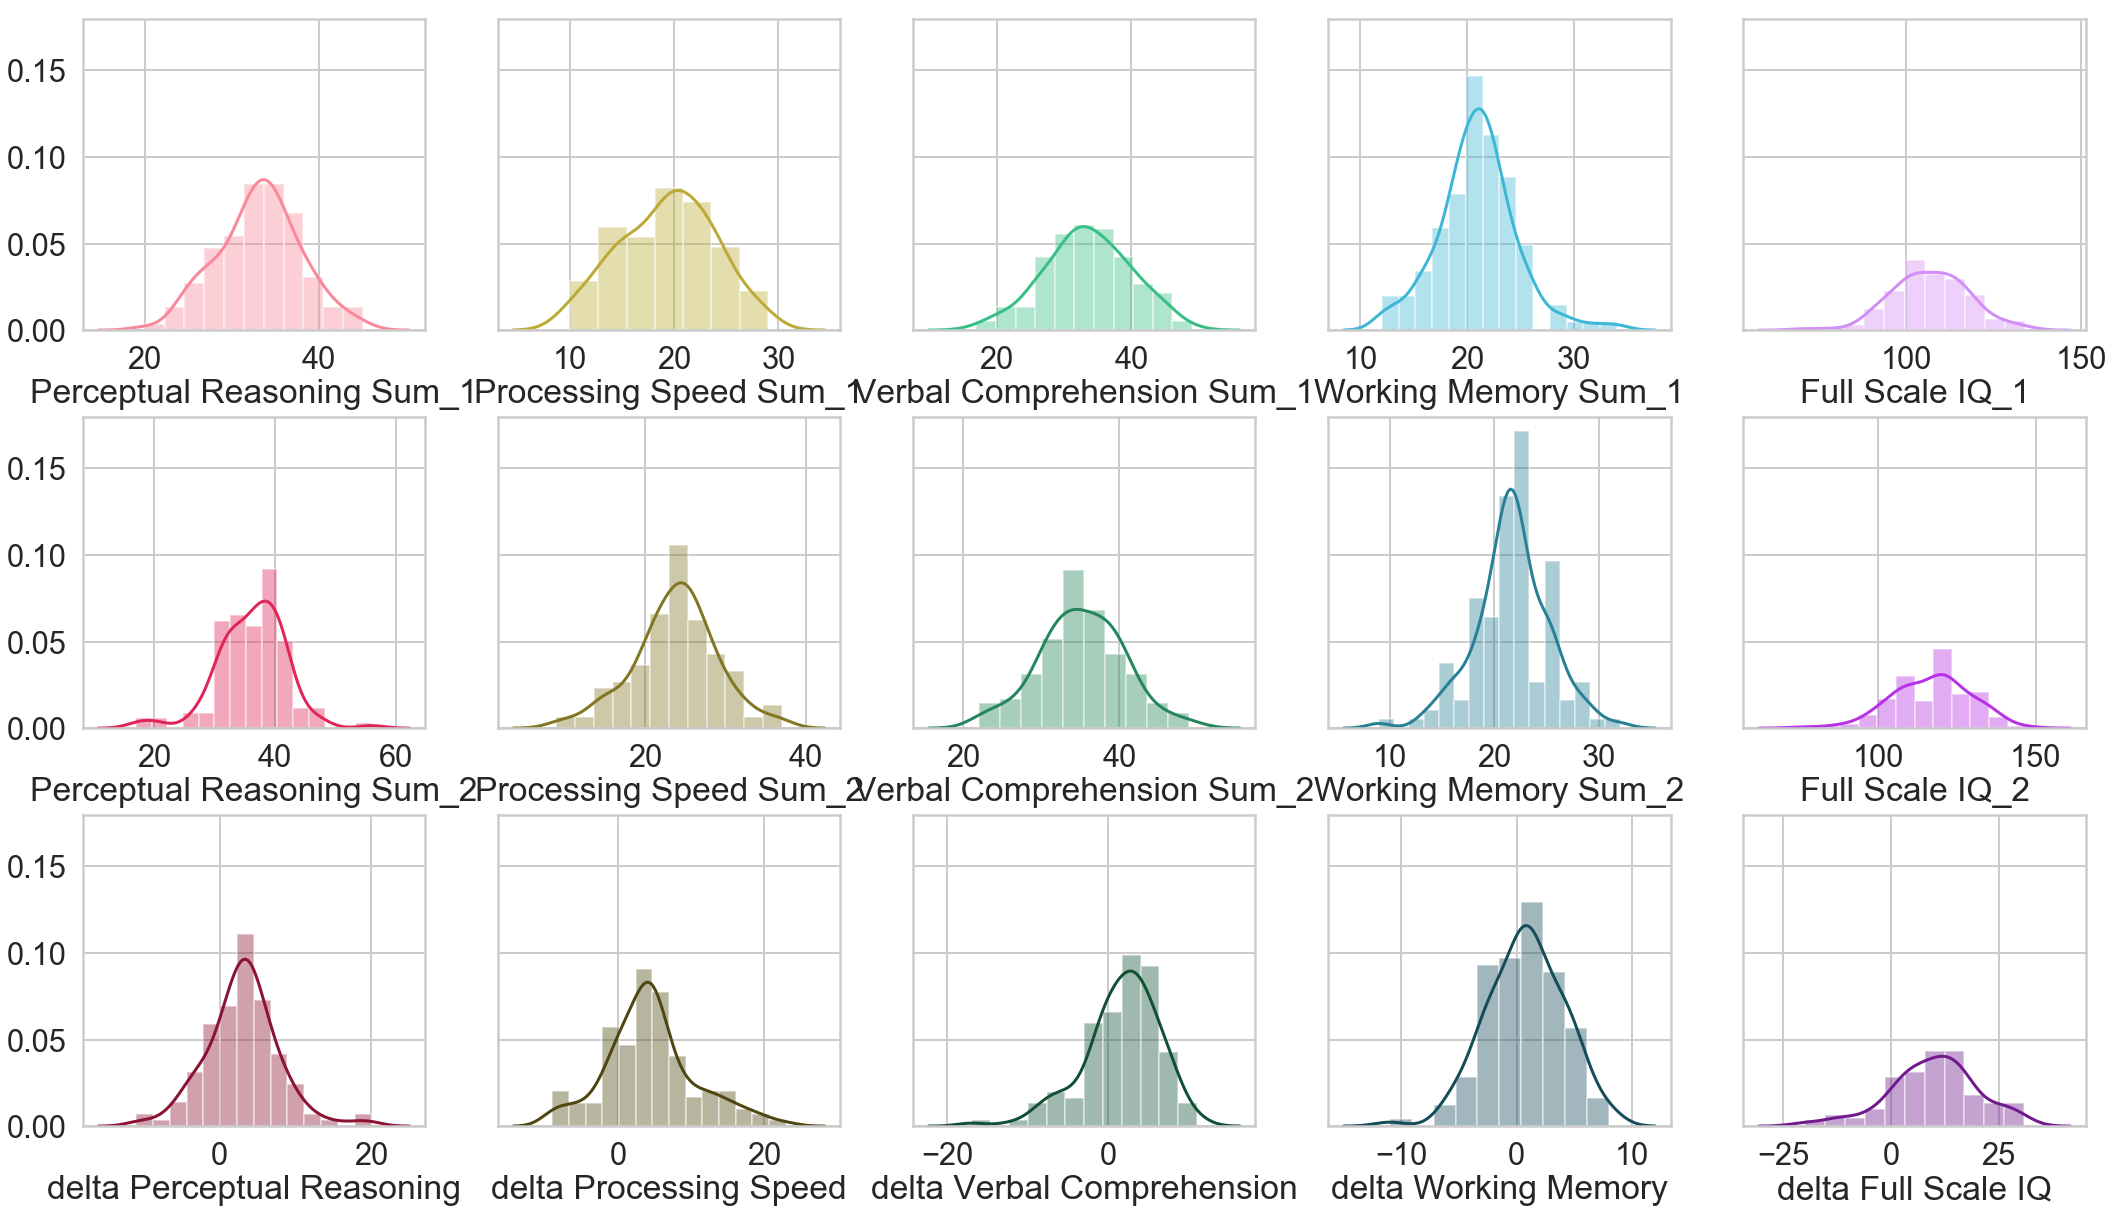

In [28]:
fig,ax = plt.subplots(nrows=3, ncols=5, sharey=True, figsize=(30, 17))
plt.tight_layout(pad=3)

for i in np.arange(0,len(iqs)):
    g = sns.distplot(imputed_df['{0}_1'.format(iqs[i])].dropna(), ax=ax[0][i], color=light_hsl[i])
    h = sns.distplot(imputed_df['{0}_2'.format(iqs[i])].dropna(), ax=ax[1][i], color=dark_hsl[i])
    if iqs[i] != 'Full Scale IQ':
        j = sns.distplot(imputed_df['delta {0}'.format(iqs[i][:-4])].dropna(), ax=ax[2][i], color=darker_hsl[i])
    else:
        j = sns.distplot(imputed_df['delta {0}'.format(iqs[i])].dropna(), ax=ax[2][i], color=darker_hsl[i])
fig.savefig(join(fig_dir, 'SI1_imputed_dist.png'), dpi=300)

In [29]:
#more data wrangling, for figure creation
imputed_df['Subject'] = all_df.index
pr_long = imputed_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['Perceptual Reasoning Sum_1', 'Perceptual Reasoning Sum_2'],
                 var_name='Session')
pr_long.replace(to_replace='Perceptual Reasoning Sum_1', value='Pre', inplace=True)
pr_long.replace(to_replace='Perceptual Reasoning Sum_2', value='Post', inplace=True)

vc_long = imputed_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['Verbal Comprehension Sum_1', 'Verbal Comprehension Sum_2'],
                 var_name='Session')
vc_long.replace(to_replace='Verbal Comprehension Sum_1', value='Pre', inplace=True)
vc_long.replace(to_replace='Verbal Comprehension Sum_2', value='Post', inplace=True)


wm_long = imputed_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['Working Memory Sum_1', 'Working Memory Sum_2'],
                 var_name='Session')
wm_long.replace(to_replace='Working Memory Sum_1', value='Pre', inplace=True)
wm_long.replace(to_replace='Working Memory Sum_2', value='Post', inplace=True)

ps_long = imputed_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['Processing Speed Sum_1', 'Processing Speed Sum_2'],
                 var_name='Session')
ps_long.replace(to_replace='Processing Speed Sum_1', value='Pre', inplace=True)
ps_long.replace(to_replace='Processing Speed Sum_2', value='Post', inplace=True)

fs_long = imputed_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['Full Scale IQ_1', 'Full Scale IQ_2'],
                 var_name='Session')
fs_long.replace(to_replace='Full Scale IQ_1', value='Pre', inplace=True)
fs_long.replace(to_replace='Full Scale IQ_2', value='Post', inplace=True)


In [30]:
pr_long['IQ'] = 'Perceptual Reasoning'
vc_long['IQ'] = 'Verbal Comprehension'
wm_long['IQ'] = 'Working Memory'
ps_long['IQ'] = 'Processing Speed'
fs_long['IQ'] = 'Full Scale IQ'

all_iq_long = pd.concat([pr_long, vc_long, wm_long, ps_long, fs_long], axis=0)
pr_long.rename({'value': 'Perceptual Reasoning'}, axis=1, inplace=True)
vc_long.rename({'value': 'Verbal Comprehension'}, axis=1, inplace=True)
wm_long.rename({'value': 'Working Memory'}, axis=1, inplace=True)
ps_long.rename({'value': 'Processing Speed'}, axis=1, inplace=True)
fs_long.rename({'value': 'Full Scale IQ'}, axis=1, inplace=True)

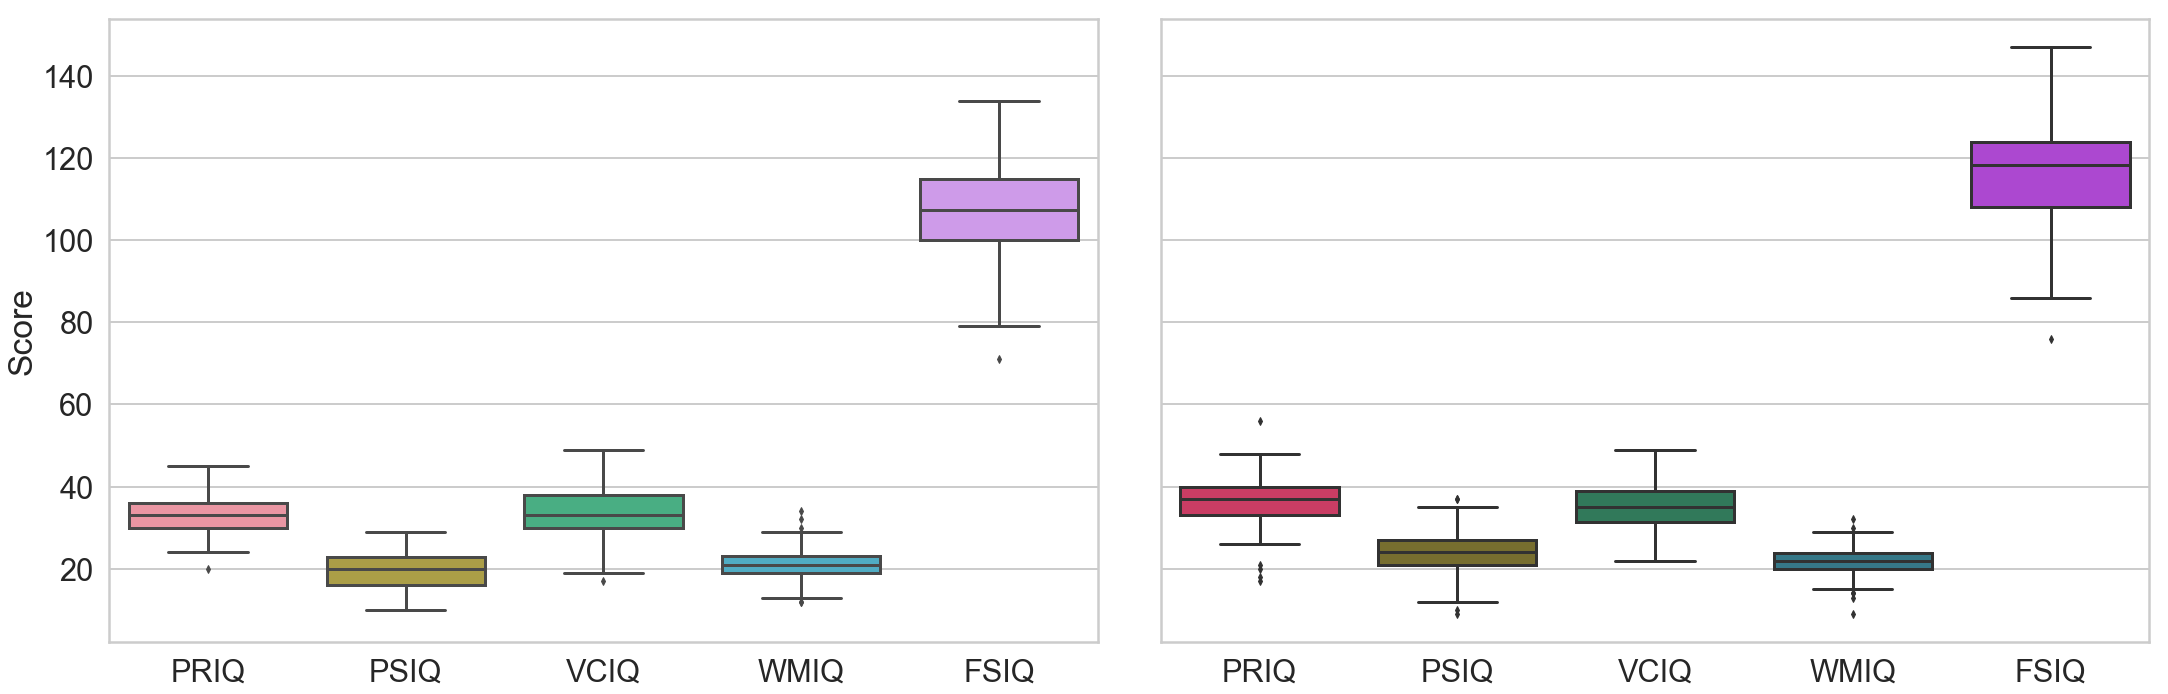

In [31]:
fig,ax = plt.subplots(ncols=2, sharey=True, figsize=(30, 10))
plt.tight_layout(pad=2)
h = sns.boxplot(x='IQ', y='value', data=all_iq_long[all_iq_long['Session'] == 'Post'], 
                order=['Perceptual Reasoning', 'Processing Speed', 'Verbal Comprehension',
                       'Working Memory', 'Full Scale IQ'], 
                ax=ax[1], palette=dark_hsl)
g = sns.boxplot(x='IQ', y='value', data=all_iq_long[all_iq_long['Session'] == 'Pre'], 
                order=['Perceptual Reasoning', 'Processing Speed', 'Verbal Comprehension',
                       'Working Memory', 'Full Scale IQ'], 
                ax=ax[0], palette=light_hsl)
g.set_xticklabels(['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ'])
h.set_xticklabels(['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ'])
g.set_xlabel('')
h.set_xlabel('')
g.set_ylabel('Score')
h.set_ylabel('')
fig.savefig(join(fig_dir, 'SI1_imputed_box.png'), dpi=300)

In [32]:
imputed_df.keys()

Index(['GPA', 'Age', 'Handedness', 'Strt.Level', 'Phy48Grade',
       'Mean Physics Retrieval Accuracy Pre', 'Mean Correct RT Pre',
       'Mean Physics Retrieval Accuracy Post', 'Mean Correct RT Post',
       'Pre Mean FCI Accuracy', 'Post Mean FCI Accuracy',
       'Verbal Comprehension Sum_1', 'Perceptual Reasoning Sum_1',
       'Working Memory Sum_1', 'Processing Speed Sum_1', 'Full Scale IQ_1',
       'Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2',
       'Working Memory Sum_2', 'Processing Speed Sum_2', 'Full Scale IQ_2',
       'delta Physics Retrieval Accuracy', 'delta FCI Accuracy',
       'delta Verbal Comprehension', 'delta Perceptual Reasoning',
       'delta Working Memory', 'delta Processing Speed', 'delta Full Scale IQ',
       'Sex', 'Ethnic.Grp', 'Class.Type', 'Subject'],
      dtype='object')

## Does IQ significantly change over the course of the semester for all students?

In [33]:
mc_alpha,_ = liji_sidak_mc(imputed_df[['Perceptual Reasoning Sum_1', 'Working Memory Sum_1',
                                   'Processing Speed Sum_1', 'Full Scale IQ_1',
                                   'Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2',
                                   'Working Memory Sum_2', 'Processing Speed Sum_2', 'Full Scale IQ_2',
                                   'delta Verbal Comprehension', 'delta Perceptual Reasoning',
                                   'delta Working Memory', 'delta Processing Speed', 'delta Full Scale IQ']], 0.05)

Number of effective comparisons: 7.471899437857925
Critical value of 0.050 becomes 0.006841 after corrections


In [34]:
coursetype = ['All', 'Modeling', 'Lecture']

delta_tests = pd.DataFrame(index=pd.MultiIndex.from_product((iqs, coursetype)), 
                           columns=['delta', 'sdev(delta)', 't(delta)', 'p(t)', 'w+', 'p(w+)'])
for i in iqs:
    delta_iq = ttest_rel(imputed_df['{0}_2'.format(i)], imputed_df['{0}_1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'All'), 'delta'] = np.average(imputed_df['{0}_2'.format(i)].dropna())-np.average(imputed_df['{0}_1'.format(i)].dropna())
    delta_tests.at[(i, 'All'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'All'), 'p(t)'] = delta_iq.pvalue
    if i != 'Full Scale IQ':
        delta_tests.at[(i, 'All'), 'sdev(delta)'] = np.std(imputed_df['delta {0}'.format(i[:-4])])
        delta_tests.at[(i, 'Modeling'), 'sdev(delta)'] = np.std(imputed_df[imputed_df['Class.Type'] == 'Mod']['delta {0}'.format(i[:-4])])
        delta_tests.at[(i, 'Lecture'), 'sdev(delta)'] = np.std(imputed_df[imputed_df['Class.Type'] == 'Lec']['delta {0}'.format(i[:-4])])
    else:
        delta_tests.at[(i, 'All'), 'sdev(delta)'] = np.std(imputed_df['delta {0}'.format(i)])
        delta_tests.at[(i, 'Modeling'), 'sdev(delta)'] = np.std(imputed_df[imputed_df['Class.Type'] == 'Mod']['delta {0}'.format(i)])
        delta_tests.at[(i, 'Lecture'), 'sdev(delta)'] = np.std(imputed_df[imputed_df['Class.Type'] == 'Lec']['delta {0}'.format(i)])
    
    delta_iq = ttest_rel(imputed_df[imputed_df['Class.Type'] == 'Mod']['{0}_2'.format(i)], imputed_df[imputed_df['Class.Type'] == 'Mod']['{0}_1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'Modeling'), 'delta'] = np.average(imputed_df[imputed_df['Class.Type'] == 'Mod']['{0}_2'.format(i)].dropna())-np.average(imputed_df[imputed_df['Class.Type'] == 'Mod']['{0}_1'.format(i)].dropna())
    delta_tests.at[(i, 'Modeling'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'Modeling'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = ttest_rel(imputed_df[imputed_df['Class.Type'] == 'Lec']['{0}_2'.format(i)], imputed_df[imputed_df['Class.Type'] == 'Lec']['{0}_1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'Lecture'), 'delta'] = np.average(imputed_df[imputed_df['Class.Type'] == 'Lec']['{0}_2'.format(i)].dropna())-np.average(imputed_df[imputed_df['Class.Type'] == 'Lec']['{0}_1'.format(i)].dropna())
    delta_tests.at[(i, 'Lecture'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'Lecture'), 'p(t)'] = delta_iq.pvalue
    

    
    delta_iq = wilcoxon(imputed_df['{0}_2'.format(i)], imputed_df['{0}_1'.format(i)])
    delta_tests.at[(i, 'All'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'All'), 'p(w+)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(imputed_df[imputed_df['Class.Type'] == 'Mod']['{0}_2'.format(i)], imputed_df[imputed_df['Class.Type'] == 'Mod']['{0}_1'.format(i)])
    delta_tests.at[(i, 'Modeling'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'Modeling'), 'p(w+)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(imputed_df[imputed_df['Class.Type'] == 'Lec']['{0}_2'.format(i)], imputed_df[imputed_df['Class.Type'] == 'Lec']['{0}_1'.format(i)])
    delta_tests.at[(i, 'Lecture'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'Lecture'), 'p(w+)'] = delta_iq.pvalue
    
        
delta_tests.to_csv(join(data_dir, 'imputed_change-in-iq.csv'))

In [35]:
delta_tests

delta sdev(delta) t(delta)         p(t)  \
Perceptual Reasoning Sum All         3.0368     4.80437  7.17919  4.94328e-11   
                         Modeling   3.27781     4.59958  5.65635  4.03932e-07   
                         Lecture     2.8031     4.98382  4.53453  2.54346e-05   
Processing Speed Sum     All        4.46682     6.16775  8.22558  1.81846e-13   
                         Modeling   5.82693     6.31493  7.32389  5.43619e-10   
                         Lecture    3.14792     5.72069  4.43642  3.61304e-05   
Verbal Comprehension Sum All        1.61299     4.70569  3.89316  0.000157905   
                         Modeling   1.89218      4.0716  3.68866   0.00047193   
                         Lecture    1.34226      5.2337  2.06768    0.0426552   
Working Memory Sum       All        0.76408     3.31431  2.61843   0.00989081   
                         Modeling  0.587093     3.36942    1.383     0.171547   
                         Lecture   0.935703     3.25078  2.32064    0.0234551   
Full Scale IQ            All        9.88069     10.2061  10.9957  2.99612e-20   
                         Modeling    11.584     8.64669  10.6336  1.07884e-15   
                         Lecture    8.22898     11.2753  5.88404  1.53116e-07   

                                       w+        p(w+)  
Perceptual Reasoning Sum All       1304.5  2.33483e-10  
                         Modeling   292.5   1.5597e-06  
                         Lecture    365.5  3.05729e-05  
Processing Speed Sum     All         1003  3.52592e-12  
                         Modeling     129   4.4035e-09  
                         Lecture    386.5  9.92032e-05  
Verbal Comprehension Sum All       1970.5  2.17696e-05  
                         Modeling   424.5  0.000297574  
                         Lecture      568    0.0166543  
Working Memory Sum       All       2573.5   0.00809691  
                         Modeling     597      0.10019  
                         Lecture    711.5    0.0419905  
Full Scale IQ            All        763.5  7.53251e-16  
                         Modeling    40.5  3.46329e-11  
                         Lecture      366  2.30431e-06

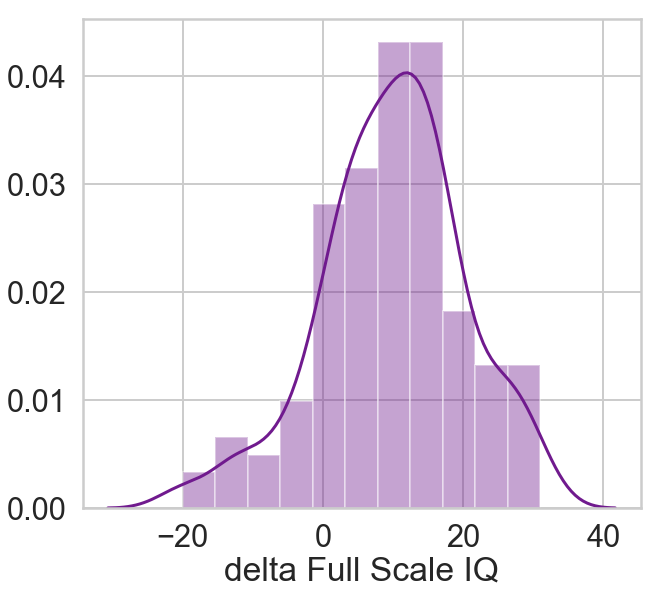

In [36]:
fig,ax = plt.subplots(figsize=(10,9))
sns.distplot(imputed_df['delta Full Scale IQ'].dropna(), color=darker_hsl[-1])
fig.savefig(join(fig_dir, 'SI-1_imputed_fsiq.png'), dpi=300)

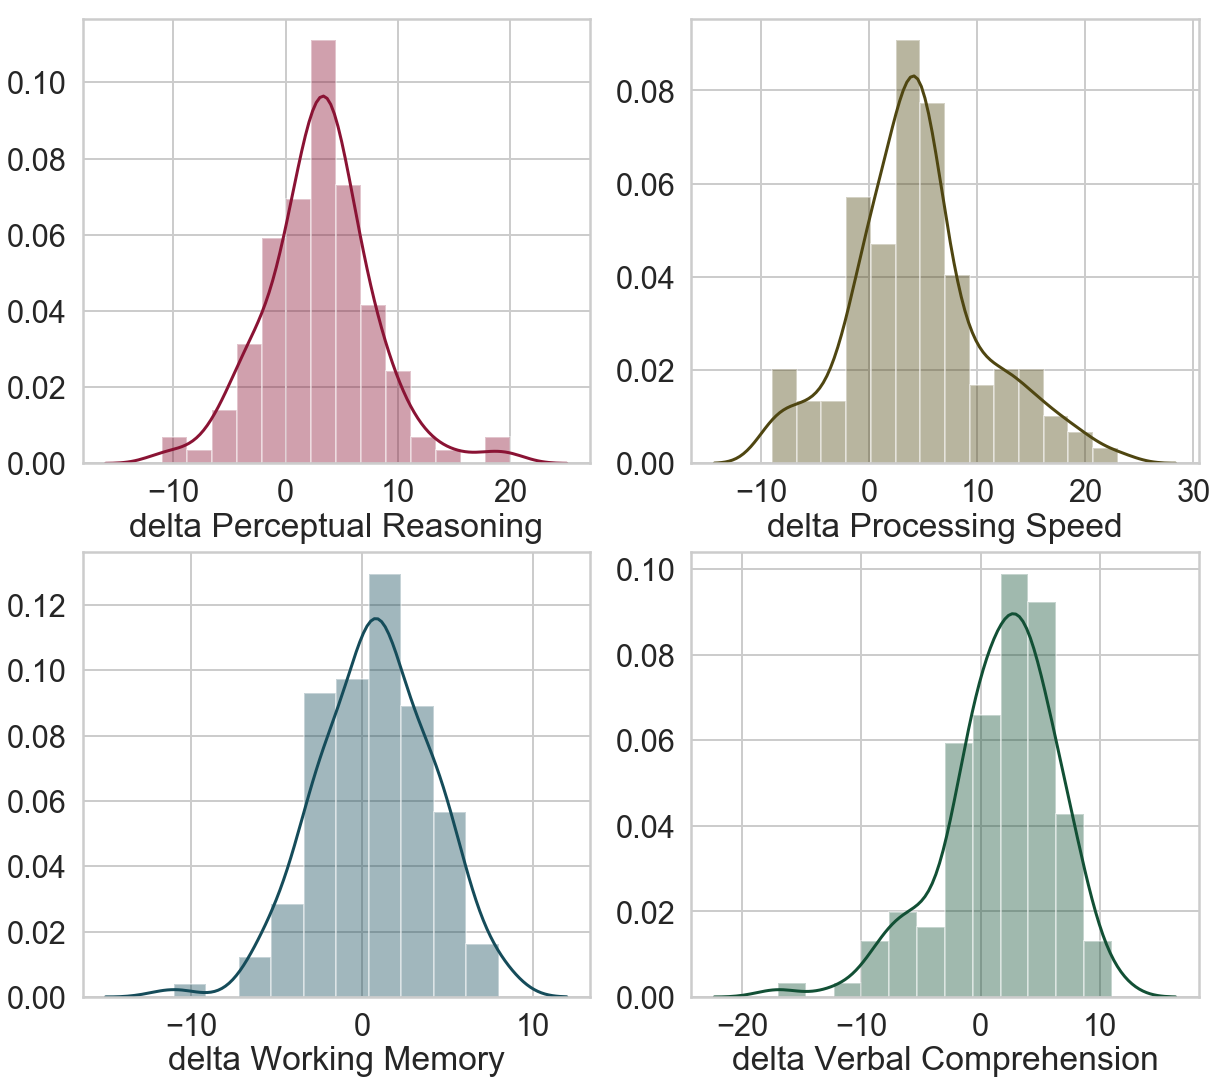

In [37]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(20,18))
sns.distplot(imputed_df['delta Perceptual Reasoning'].dropna(), ax=ax[0][0], color=darker_hsl[0])
sns.distplot(imputed_df['delta Processing Speed'].dropna(), ax=ax[0][1], color=darker_hsl[1])
sns.distplot(imputed_df['delta Working Memory'].dropna(), ax=ax[1][0], color=darker_hsl[3])
sns.distplot(imputed_df['delta Verbal Comprehension'].dropna(), ax=ax[1][1], color=darker_hsl[2])
fig.savefig(join(fig_dir, 'SI-1_imputed_histograms.png'), dpi=300)

## Are there significant sex differences in IQ?

In [38]:
sessions = ['pre', 'post']
coursetype = ['All', 'Modeling', 'Lecture']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sessions, iqs, coursetype), 
                                                            names=['session', 'iq', 'course']),
                           columns=['t(diff)', 'p(t)', 'U', 'p(U)'])

for i in np.arange(0, len(sessions)):
    for iq in iqs:
        delta_iq = ttest_ind(df_f['{0}_{1}'.format(iq, i+1)], df_m['{0}_{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'All'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f['{0}_{1}'.format(iq, i+1)], df_m['{0}_{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'p(U)'] = delta_iq.pvalue

        delta_iq = ttest_ind(df_f[df_f['Class.Type'] == 'Mod']['{0}_{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Mod']['{0}_{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f[df_f['Class.Type'] == 'Mod']['{0}_{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Mod']['{0}_{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'p(U)'] = delta_iq.pvalue

        delta_iq = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['{0}_{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Lec']['{0}_{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['{0}_{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Lec']['{0}_{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'p(U)'] = delta_iq.pvalue
        

In [39]:
sex_diff_iq.to_csv(join(data_dir, 'imputed_sex_differences_pre_post_iq.csv'))
sex_diff_iq

t(diff)        p(t)       U  \
session iq                       course                                   
pre     Perceptual Reasoning Sum All       -2.75298  0.00676463  1504.5   
                                 Modeling  -1.58531    0.117984     381   
                                 Lecture   -2.35369    0.021671     357   
        Processing Speed Sum     All        1.03756    0.301433  1883.5   
                                 Modeling  0.405346    0.686619     461   
                                 Lecture   0.973314    0.334062   471.5   
        Verbal Comprehension Sum All       -2.01546   0.0459503    1611   
                                 Modeling  -3.03335  0.00352974     278   
                                 Lecture  -0.437198     0.66344     473   
        Working Memory Sum       All       -1.18432     0.23848    1903   
                                 Modeling -0.535912    0.593937     476   
                                 Lecture    -1.1639    0.248785   463.5   
        Full Scale IQ            All       -2.38762   0.0184198  1640.5   
                                 Modeling  -2.38164   0.0203191     329   
                                 Lecture   -1.35116    0.181402   450.5   
post    Perceptual Reasoning Sum All       -3.72453   0.0002922  1340.5   
                                 Modeling  -2.85544  0.00583904   306.5   
                                 Lecture   -2.38819   0.0198932     348   
        Processing Speed Sum     All       0.127029    0.899117    2062   
                                 Modeling  0.896292    0.373564     395   
                                 Lecture  -0.279218    0.780978   490.5   
        Verbal Comprehension Sum All       -2.64075   0.0093022  1538.5   
                                 Modeling   -3.1917  0.00222138   275.5   
                                 Lecture   -1.08907    0.280209   459.5   
        Working Memory Sum       All       -1.91135   0.0581955    1735   
                                 Modeling  -1.66872    0.100215     349   
                                 Lecture   -1.12885    0.263174     514   
        Full Scale IQ            All       -3.36795   0.0010007  1437.5   
                                 Modeling  -2.63638   0.0105752     321   
                                 Lecture    -2.1101   0.0387647     384   

                                                  p(U)  
session iq                       course                 
pre     Perceptual Reasoning Sum All        0.00255506  
                                 Modeling     0.061748  
                                 Lecture    0.00866152  
        Processing Speed Sum     All          0.151546  
                                 Modeling     0.328115  
                                 Lecture       0.18216  
        Verbal Comprehension Sum All         0.0106791  
                                 Modeling   0.00159138  
                                 Lecture       0.18748  
        Working Memory Sum       All          0.173604  
                                 Modeling     0.405091  
                                 Lecture      0.156101  
        Full Scale IQ            All         0.0152683  
                                 Modeling      0.01222  
                                 Lecture      0.119782  
post    Perceptual Reasoning Sum All        0.00018119  
                                 Modeling   0.00521421  
                                 Lecture    0.00629965  
        Processing Speed Sum     All          0.422242  
                                 Modeling    0.0886602  
                                 Lecture      0.253808  
        Verbal Comprehension Sum All        0.00412868  
                                 Modeling   0.00141616  
                                 Lecture       0.14429  
        Working Memory Sum       All         0.0421616  
                                 Modeling      0.02377  
                                 Lecture      0

## Significant changes in IQ pre- to post-instruction, separated by sex

In [40]:
sessions = ['pre', 'post']
coursetype = ['All', 'Mod', 'Lec', 'Difference (Lec - Mod)']
sexes = ['Female', 'Male']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sexes, iqs, coursetype), 
                                                            names=['Sex', 'iq', 'course']), 
                           columns=['t(diff)', 'p(t)', 'np', 'p(np)'])

for iq in iqs:
    
    delta_iq = ttest_rel(df_f['{0}_2'.format(iq)], df_f['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'All'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class.Type'] == 'Mod']['{0}_2'.format(iq)], df_f[df_f['Class.Type'] == 'Mod']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Mod'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Mod'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class.Type'] == 'Lec']['{0}_2'.format(iq)], df_f[df_f['Class.Type'] == 'Lec']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Lec'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Lec'), 'p(t)'] = delta_iq.pvalue
    
    
    delta_iq = wilcoxon(df_f['{0}_2'.format(iq)], df_f['{0}_1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'All'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'All'), 'p(np)'] = delta_iq.pvalue

    delta_iq = wilcoxon(df_f[df_f['Class.Type'] == 'Mod']['{0}_2'.format(iq)], 
                        df_f[df_f['Class.Type'] == 'Mod']['{0}_1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'Mod'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Mod'), 'p(np)'] = delta_iq.pvalue

    delta_iq = wilcoxon(df_f[df_f['Class.Type'] == 'Lec']['{0}_2'.format(iq)], 
                        df_f[df_f['Class.Type'] == 'Lec']['{0}_1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'Lec'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Lec'), 'p(np)'] = delta_iq.pvalue
    
    if iq == 'Full Scale IQ':
        delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['delta {0}'.format(iq)], 
                             df_f[df_f['Class.Type'] == 'Mod']['delta {0}'.format(iq)], nan_policy='omit')
        delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['delta {0}'.format(iq)], 
                             df_f[df_f['Class.Type'] == 'Mod']['delta {0}'.format(iq)])
    else:
        delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['delta {0}'.format(iq[:-4])], 
                             df_f[df_f['Class.Type'] == 'Mod']['delta {0}'.format(iq[:-4])], nan_policy='omit')
        delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['delta {0}'.format(iq[:-4])], 
                             df_f[df_f['Class.Type'] == 'Mod']['delta {0}'.format(iq[:-4])])
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq_p.pvalue
    
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'p(np)'] = delta_iq_np.pvalue
    
    delta_iq = ttest_rel(df_m['{0}_2'.format(iq)], df_m['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'All'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m['{0}_2'.format(iq)], df_m['{0}_1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'All'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'All'), 'p(np)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class.Type'] == 'Mod']['{0}_2'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Mod']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Mod'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Mod'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m[df_m['Class.Type'] == 'Mod']['{0}_2'.format(iq)], 
                        df_m[df_m['Class.Type'] == 'Mod']['{0}_1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Mod'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Mod'), 'p(np)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class.Type'] == 'Lec']['{0}_2'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Lec']['{0}_1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Lec'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Lec'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m[df_m['Class.Type'] == 'Lec']['{0}_2'.format(iq)], 
                        df_m[df_m['Class.Type'] == 'Lec']['{0}_1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Lec'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Lec'), 'p(np)'] = delta_iq.pvalue
    
    if iq == 'Full Scale IQ':
        delta_iq_p = ttest_ind(df_m[df_m['Class.Type'] == 'Lec']['delta {0}'.format(iq)], 
                             df_m[df_m['Class.Type'] == 'Mod']['delta {0}'.format(iq)], nan_policy='omit')
        delta_iq_np = mannwhitneyu(df_m[df_m['Class.Type'] == 'Lec']['delta {0}'.format(iq)], 
                             df_m[df_m['Class.Type'] == 'Mod']['delta {0}'.format(iq)])
    else:
        delta_iq_p = ttest_ind(df_m[df_m['Class.Type'] == 'Lec']['delta {0}'.format(iq[:-4])], 
                             df_m[df_m['Class.Type'] == 'Mod']['delta {0}'.format(iq[:-4])], nan_policy='omit')
        delta_iq_np = mannwhitneyu(df_m[df_m['Class.Type'] == 'Lec']['delta {0}'.format(iq[:-4])], 
                             df_m[df_m['Class.Type'] == 'Mod']['delta {0}'.format(iq[:-4])])
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq_p.pvalue
    
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'p(np)'] = delta_iq_np.pvalue

In [41]:
sex_diff_iq

t(diff)  \
Sex    iq                       course                              
Female Perceptual Reasoning Sum All                       3.85411   
                                Mod                       2.36631   
                                Lec                       3.00732   
                                Difference (Lec - Mod)   0.347479   
       Processing Speed Sum     All                       4.62426   
                                Mod                       4.46877   
                                Lec                        2.3064   
                                Difference (Lec - Mod)   -2.17683   
       Verbal Comprehension Sum All                       2.20468   
                                Mod                       2.41252   
                                Lec                       1.02479   
                                Difference (Lec - Mod)  -0.835946   
       Working Memory Sum       All                       1.29822   
                                Mod                      -0.11425   
                                Lec                       1.96765   
                                Difference (Lec - Mod)    1.28913   
       Full Scale IQ            All                       6.43533   
                                Mod                       5.42375   
                                Lec                       3.94416   
                                Difference (Lec - Mod)   -1.29424   
Male   Perceptual Reasoning Sum All                       6.26641   
                                Mod                       5.47762   
                                Lec                       3.37254   
                                Difference (Lec - Mod)  -0.829373   
       Processing Speed Sum     All                       7.23444   
                                Mod                       5.82223   
                                Lec                       4.34346   
                                Difference (Lec - Mod)   -1.22681   
       Verbal Comprehension Sum All                       3.41854   
                                Mod                       2.76751   
                                Lec                       2.06839   
                                Difference (Lec - Mod)  0.0120937   
       Working Memory Sum       All                       2.34402   
                                Mod                       1.95295   
                                Lec                       1.33585   
                                Difference (Lec - Mod)  -0.210136   
       Full Scale IQ            All                       9.12888   
                                Mod                       9.63031   
                                Lec                       4.35581   
                                Difference (Lec - Mod)   -1.13174   

                                                               p(t)     np  \
Sex    iq                       course                                       
Female Perceptual Reasoning Sum All                     0.000285422    386   
                                Mod                       0.0260256   82.5   
                                Lec                        0.004931  117.5   
                                Difference (Lec - Mod)     0.729468    415   
       Processing Speed Sum     All                     2.05035e-05  293.5   
                                Mod                     0.000147672     24   
                                Lec                       0.0273124  142.5   
                                Difference (Lec - Mod)     0.033507    319   
       Verbal Comprehension Sum All                        0.031322    509   
                                Mod                       0.0235069   74.5   
                                Lec                        0.312697  194.5   
                                Difference (Lec - Mod)     0.406558    432   
       Working Memory Sum       All                        0.199181

# Sex differences in the change in IQ

In [42]:
#sex differences (F>M) in the change in IQ

sessions = ['pre', 'post']
coursetype = ['All', 'Mod', 'Lec']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((iqs, coursetype), 
                                                            names=['iq', 'course']), 
                           columns=['t(diff)', 'p(t)', 'np', 'p(np)'])

for iq in iqs:
    if iq != 'Full Scale IQ':
        i = iq[:-4]
    else:
        i = iq
    #both classes
    delta_iq_p = ttest_ind(df_f['delta {0}'.format(i)],
                           df_m['delta {0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f['delta {0}'.format(i)],
                               df_m['delta {0}'.format(i)])

    sex_diff_iq.at[(iq, 'All'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'All'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'All'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'All'), 'p(np)'] = delta_iq_np.pvalue

    #Lecture
    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['delta {0}'.format(i)],
                           df_m[df_m['Class.Type'] == 'Lec']['delta {0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['delta {0}'.format(i)],
                               df_m[df_m['Class.Type'] == 'Lec']['delta {0}'.format(i)])
    sex_diff_iq.at[(iq, 'Lec'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'Lec'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'Lec'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'Lec'), 'p(np)'] = delta_iq_np.pvalue

    #Modeling
    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Mod']['delta {0}'.format(i)],
                           df_m[df_m['Class.Type'] == 'Mod']['delta {0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Mod']['delta {0}'.format(i)],
                               df_m[df_m['Class.Type'] == 'Mod']['delta {0}'.format(i)])

    sex_diff_iq.at[(iq, 'Mod'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'Mod'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'Mod'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'Mod'), 'p(np)'] = delta_iq_np.pvalue

In [43]:
sex_diff_iq

t(diff)       p(t)      np      p(np)
iq                       course                                        
Perceptual Reasoning Sum All     -1.54352   0.125174    1827  0.0978134
                         Mod     -1.70827  0.0925892     369  0.0439539
                         Lec     -0.46703   0.642065     540   0.489739
Processing Speed Sum     All    -0.649758   0.517013    1945   0.228901
                         Mod     0.445747   0.657333     461   0.328213
                         Lec    -0.999591   0.321273   458.5   0.141428
Verbal Comprehension Sum All    -0.244416     0.8073  2057.5   0.414002
                         Mod     0.442878   0.659395     461   0.328075
                         Lec    -0.537848   0.592548   535.5   0.466676
Working Memory Sum       All    -0.726857   0.468641  1964.5   0.257051
                         Mod     -1.30406   0.197036     390  0.0779043
                         Lec     0.157934   0.875006     501   0.298572
Full Scale IQ            All     -1.47247    0.14335  1759.5  0.0539392
                         Mod    -0.861249   0.392419   432.5   0.202001
                         Lec    -0.918898   0.361599   459.5   0.144492

## differences in the change in IQ wrt sex and class
(the regression approach)

In [44]:
#making dummy variables for class type
class_dumb = pd.get_dummies(imputed_df['Class.Type'])
df_f = pd.concat((imputed_df, class_dumb), axis=1)

class_dumb = pd.get_dummies(imputed_df['Class.Type'])
df_m = pd.concat((imputed_df, class_dumb), axis=1)

class_dumb = pd.get_dummies(imputed_df['Class.Type'])
imputed_df = pd.concat((imputed_df, class_dumb), axis=1)

In [45]:
dumb = pd.get_dummies(imputed_df['Sex'])
imputed_df['F'] = dumb['F']

In [46]:
imputed_df['SexXClass'] = (imputed_df['F'] + 1) * (imputed_df['Mod'] + 1)

In [47]:
for iq_meas in iqs:
    df_f['{0}_1XClass'.format(iq_meas)] = df_f['{0}_1'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_f['{0}_2XClass'.format(iq_meas)] = df_f['{0}_2'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_m['{0}_1XClass'.format(iq_meas)] = df_m['{0}_1'.format(iq_meas)] * (df_m['Mod'] + 1)
    df_m['{0}_2XClass'.format(iq_meas)] = df_m['{0}_2'.format(iq_meas)] * (df_m['Mod'] + 1)
    imputed_df['{0}_1XClass'.format(iq_meas)] = imputed_df['{0}_1'.format(iq_meas)] * (imputed_df['Mod'] + 1)
    imputed_df['{0}_2XClass'.format(iq_meas)] = imputed_df['{0}_2'.format(iq_meas)] * (imputed_df['Mod'] + 1)
    if iq_meas == 'Full Scale IQ':
        df_f['delta {0}XClass'.format(iq_meas)] = df_f['delta {0}'.format(iq_meas)] * (df_f['Mod'] + 1)
        df_m['delta {0}XClass'.format(iq_meas)] = df_m['delta {0}'.format(iq_meas)] * (df_m['Mod'] + 1)
        imputed_df['delta {0}XClass'.format(iq_meas)] = imputed_df['delta {0}'.format(iq_meas)] * (imputed_df['Mod'] + 1)
    else:
        df_f['delta {0}XClass'.format(iq_meas)] = df_f['delta {0}'.format(iq_meas[:-4])] * (df_f['Mod'] + 1)
        df_m['delta {0}XClass'.format(iq_meas)] = df_m['delta {0}'.format(iq_meas[:-4])] * (df_m['Mod'] + 1)
        imputed_df['delta {0}XClass'.format(iq_meas)] = imputed_df['delta {0}'.format(iq_meas[:-4])] * (imputed_df['Mod'] + 1)


In [48]:
for iq_meas in iqs:
    imputed_df['{0}_1XClassXSex'.format(iq_meas)] = imputed_df['{0}_1XClass'.format(iq_meas)] * (imputed_df['F'] + 1)
    imputed_df['{0}_1XSex'.format(iq_meas)] = imputed_df['{0}_1'.format(iq_meas)] * (imputed_df['F'] + 1)
    imputed_df['{0}_2XClassXSex'.format(iq_meas)] = imputed_df['{0}_1XClass'.format(iq_meas)] * (imputed_df['F'] + 1)
    imputed_df['{0}_2XSex'.format(iq_meas)] = imputed_df['{0}_1'.format(iq_meas)] * (imputed_df['F'] + 1)
    if iq_meas == 'Full Scale IQ':
        imputed_df['delta {0}XClassXSex'.format(iq_meas)] = imputed_df['delta {0}XClass'.format(iq_meas)] * (imputed_df['F'] + 1)
        imputed_df['delta {0}XSex'.format(iq_meas)] = imputed_df['delta {0}'.format(iq_meas)] * (imputed_df['F'] + 1)
    else:
        imputed_df['delta {0}XClassXSex'.format(iq_meas)] = imputed_df['delta {0} SumXClass'.format(iq_meas[:-4])] * (imputed_df['F'] + 1)
        imputed_df['delta {0}XSex'.format(iq_meas)] = imputed_df['delta {0}'.format(iq_meas[:-4])] * (imputed_df['F'] + 1)

In [49]:
sexes = ['Male', 'Female', 'All']

In [50]:
p_corr,_ = liji_sidak_mc(imputed_df, 0.05)

Number of effective comparisons: 20.362476737670065
Critical value of 0.050 becomes 0.002516 after corrections


In [51]:
#let's use regressions instead
index = pd.MultiIndex.from_product((sexes,iqs))
iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'Class_pval'])

for iq_meas in iqs:
    if iq_meas == 'Full Scale IQ':
        y = imputed_df['delta {0}'.format(iq_meas)]
    else:
        y = imputed_df['delta {0}'.format(iq_meas[:-4])]
    x = imputed_df[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('All', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('All', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('All', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('All', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('All', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]
    if grade_on_delta_iq.f_pvalue < p_corr:
        print(grade_on_delta_iq.summary())
    
    if iq_meas == 'Full Scale IQ':
        y = df_m['delta {0}'.format(iq_meas)]
    else:
        y = df_m['delta {0}'.format(iq_meas[:-4])]
    x = df_m[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_pre_iq = reg1.fit()
    iqXclassXsex.at[('Male', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
    iqXclassXsex.at[('Male', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
    iqXclassXsex.at[('Male', iq_meas), 'AIC'] = grade_on_pre_iq.aic
    iqXclassXsex.at[('Male', iq_meas), 'BIC'] = grade_on_pre_iq.bic
    iqXclassXsex.at[('Male', iq_meas), 'Class_pval'] = grade_on_pre_iq.pvalues[1]
    if grade_on_pre_iq.f_pvalue < p_corr:
        print(grade_on_pre_iq.summary())
    
    if iq_meas == 'Full Scale IQ':
        y = df_f['delta {0}'.format(iq_meas)]
    else:
        y = df_f['delta {0}'.format(iq_meas[:-4])]
    x = df_f[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('Female', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('Female', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('Female', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('Female', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('Female', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]
    if grade_on_delta_iq.f_pvalue < p_corr:
        print(grade_on_delta_iq.summary())
iqXclassXsex

F-statistic Prob (F-statistic)      AIC  \
Male   Perceptual Reasoning Sum    0.399908             0.7533  783.769   
       Processing Speed Sum         2.29488          0.0810371  843.035   
       Verbal Comprehension Sum      2.1518          0.0970268   773.11   
       Working Memory Sum          0.641442           0.589743  686.498   
       Full Scale IQ                1.46088           0.228429  976.456   
Female Perceptual Reasoning Sum    0.399908             0.7533  783.769   
       Processing Speed Sum         2.29488          0.0810371  843.035   
       Verbal Comprehension Sum      2.1518          0.0970268   773.11   
       Working Memory Sum          0.641442           0.589743  686.498   
       Full Scale IQ                1.46088           0.228429  976.456   
All    Perceptual Reasoning Sum    0.399908             0.7533  783.769   
       Processing Speed Sum         2.29488          0.0810371  843.035   
       Verbal Comprehension Sum      2.1518          0.0970268   773.11   
       Working Memory Sum          0.641442           0.589743  686.498   
       Full Scale IQ                1.46088           0.228429  976.456   

                                     BIC Class_pval  
Male   Perceptual Reasoning Sum  795.239   0.539051  
       Processing Speed Sum      854.505  0.0131648  
       Verbal Comprehension Sum   784.58   0.608459  
       Working Memory Sum        697.968   0.513369  
       Full Scale IQ             987.926  0.0712832  
Female Perceptual Reasoning Sum  795.239   0.539051  
       Processing Speed Sum      854.505  0.0131648  
       Verbal Comprehension Sum   784.58   0.608459  
       Working Memory Sum        697.968   0.513369  
       Full Scale IQ             987.926  0.0712832  
All    Perceptual Reasoning Sum  795.239   0.539051  
       Processing Speed Sum      854.505  0.0131648  
       Verbal Comprehension Sum   784.58   0.608459  
       Working Memory Sum        697.968   0.513369  
       Full Scale IQ             987.926  0.0712832

In [52]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

f = sns.diverging_palette(8.2, 44, s=85, l=50, n=200)
m = sns.diverging_palette(243, 278, s=85, l=50, n=200)

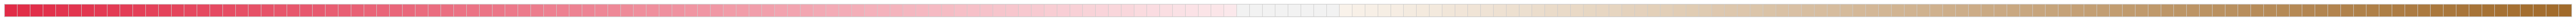

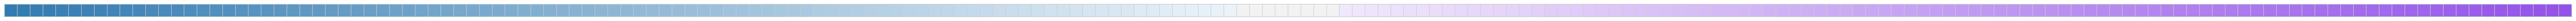

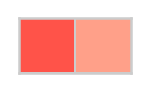

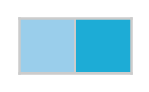

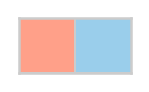

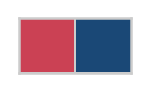

In [53]:
sns.palplot(f)
sns.palplot(m)

sns.palplot(f_2)
sns.palplot(m_2)

sns.palplot(crayons_l)
sns.palplot(crayons_d)

In [54]:
corrfonty = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'center',
             'horizontalalignment': 'right'}
corrfontx = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'top',
             'horizontalalignment': 'center'}

In [55]:
fs_long.head()

Sex  Subject Class.Type Session  Full Scale IQ             IQ
0   F      101        Lec     Pre      91.000000  Full Scale IQ
1   M      102        Mod     Pre     107.000000  Full Scale IQ
2   M      103        Lec     Pre      97.000000  Full Scale IQ
3   F      104        Mod     Pre     105.000000  Full Scale IQ
4   M      105        Lec     Pre     104.587571  Full Scale IQ

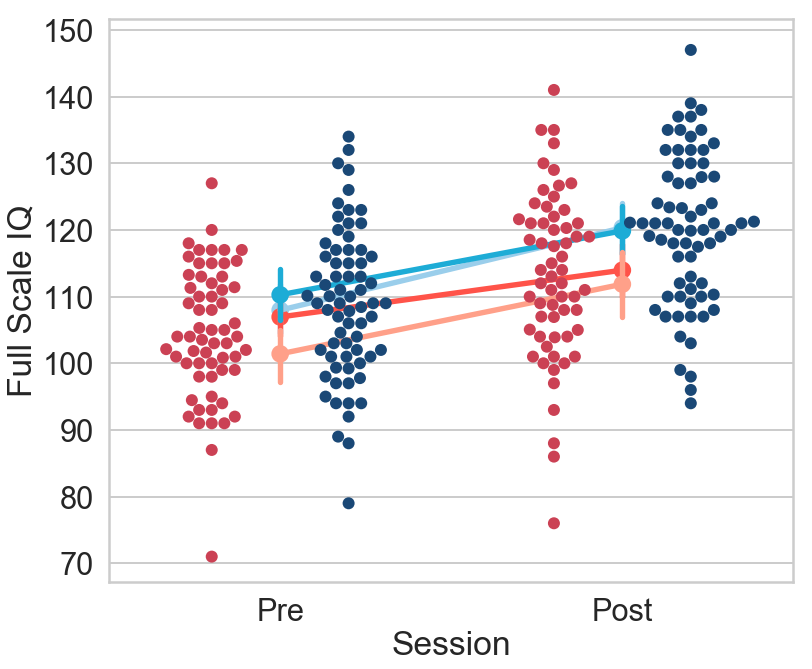

In [56]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
plt.tight_layout(pad=5)
mksz = 12
k = sns.swarmplot(x='Session', y='Full Scale IQ', hue='Sex', data=fs_long, palette=crayons_d, dodge=True, ax=ax, size=mksz)
k.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Class.Type', data=fs_long[fs_long['Sex'] == 'M'], ax=ax, palette=m_2)
j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Class.Type', data=fs_long[fs_long['Sex'] == 'F'], ax=ax, palette=f_2)
j.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_imputed_change-IQ.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-vcIQ.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-prIQ.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-wmIQ.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
mksz = 10
plt.tight_layout(pad=5)
k = sns.pointplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-psIQ.png', dpi=300)

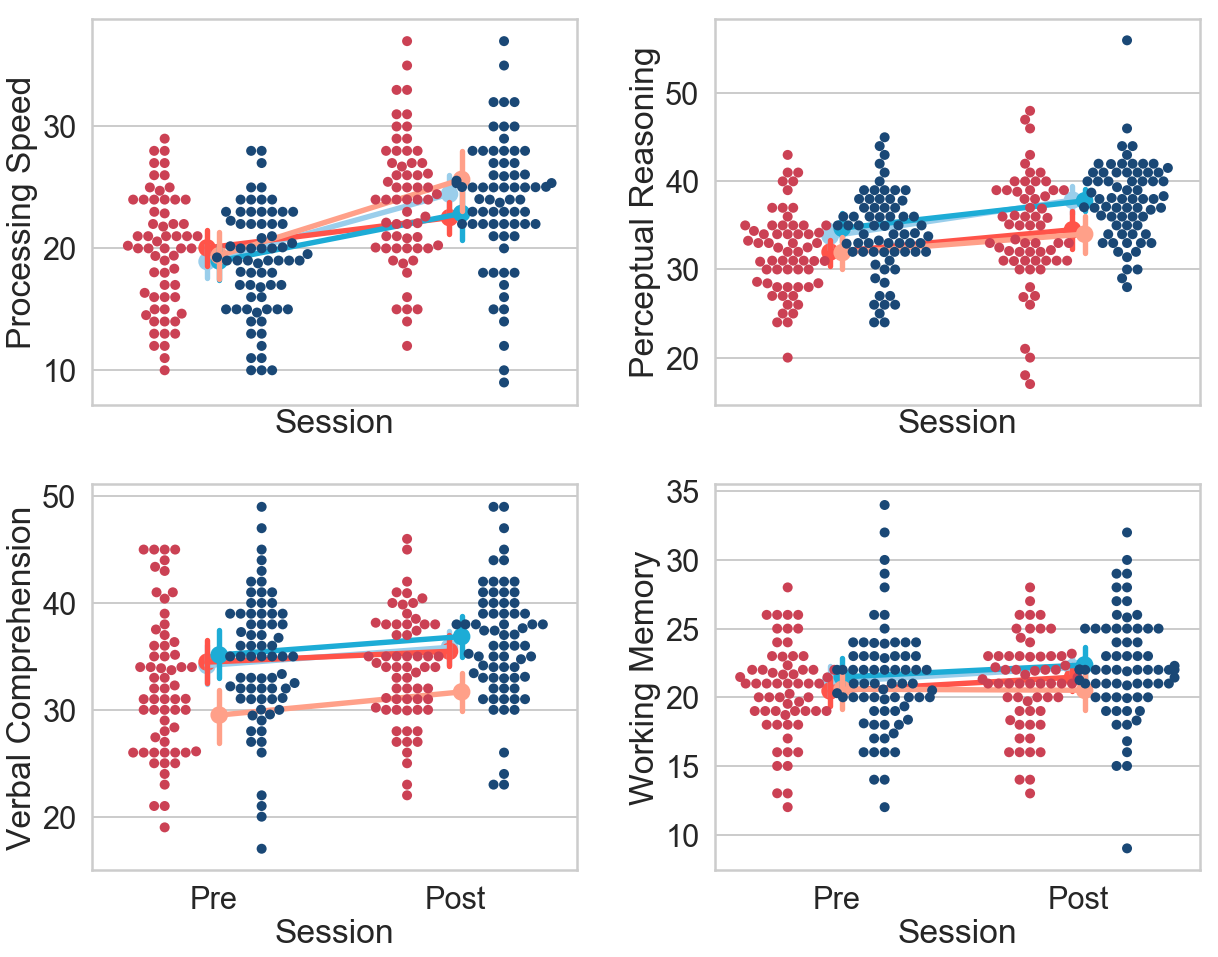

In [57]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 14), sharex=True, sharey=False, squeeze=True)
mksz = 10
plt.tight_layout(pad=5)

h = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Class.Type', data=pr_long[pr_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[0][1], size=mksz, dodge=True)
h = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Class.Type', data=pr_long[pr_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[0][1], size=mksz, dodge=True)
h.get_legend().set_visible(False)


i = sns.pointplot(x='Session', y='Processing Speed', hue='Class.Type', data=ps_long[ps_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[0][0], size=mksz, dodge=True)
i = sns.pointplot(x='Session', y='Processing Speed', hue='Class.Type', data=ps_long[ps_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[0][0], size=mksz, dodge=True)
i.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Class.Type', data=vc_long[vc_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][0], size=mksz, dodge=True)
j = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Class.Type', data=vc_long[vc_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][0], size=mksz, dodge=True)
j.get_legend().set_visible(False)

k = sns.pointplot(x='Session', y='Working Memory', hue='Class.Type', data=wm_long[wm_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][1], size=mksz, dodge=True)
k = sns.pointplot(x='Session', y='Working Memory', hue='Class.Type', data=wm_long[wm_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][1], size=mksz, dodge=True)
k.get_legend().set_visible(False)


h = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax[0][1], size=mksz, dodge=True)
h.get_legend().set_visible(False)
i = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax[1][1], size=mksz, dodge=True)
i.get_legend().set_visible(False)
j = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax[0][0], size=mksz, dodge=True)
j.get_legend().set_visible(False)
k = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, 
              palette=crayons_d, ax=ax[1][0], size=mksz, dodge=True)
k.get_legend().set_visible(False)


fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ-subscores.png', dpi=300)

## Does IQ facilitate learning?
Is pre-instruction IQ significantly related to academic performance or change in physics knowledge/reasoning?

## Does IQ reflect learning?
Is the change in IQ over the duration of the course related to academic performance or change in physics knowledge/reasoning?

In [58]:
sessions.append('delta')

In [59]:
mc_alpha,_ = liji_sidak_mc(all_df, 0.05)

Number of effective comparisons: 15.381175705475263
Critical value of 0.050 becomes 0.003329 after corrections


In [61]:
#is there a difference in accuracy/performance between classes?
print(ttest_ind(imputed_df[imputed_df['Mod'] == 1]['Phy48Grade'], 
                imputed_df[imputed_df['Mod'] == 0]['Phy48Grade'], nan_policy='omit'))
print(ttest_ind(imputed_df[imputed_df['Mod'] == 1]['Mean Physics Retrieval Accuracy Post'], 
                imputed_df[imputed_df['Mod'] == 0]['Mean Physics Retrieval Accuracy Post'], nan_policy='omit'))
print(ttest_ind(imputed_df[imputed_df['Mod'] == 1]['Post Mean FCI Accuracy'], 
                imputed_df[imputed_df['Mod'] == 0]['Post Mean FCI Accuracy'], nan_policy='omit'))

Ttest_indResult(statistic=1.747795087257421, pvalue=0.0828974631456818)
Ttest_indResult(statistic=-1.6542374293724207, pvalue=0.10052952535357298)
Ttest_indResult(statistic=-0.4532397903212802, pvalue=0.6511434859522429)


In [62]:
outcomes = ['Phy48Grade', 'Mean Physics Retrieval Accuracy Post', 'Post Mean FCI Accuracy', 
            'delta Physics Retrieval Accuracy', 'delta FCI Accuracy']
covariates = ['Age', 'Mod', 'Strt.Level', 'F']

In [63]:
index = pd.MultiIndex.from_product((sessions, iqs))
perf_iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                        'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval', 
                                                        'IQXClass_pval', 'SexXClass_pval', 'IQXSex_pval', 
                                                        'IQXClassXSex_pval'])
for outcome in outcomes:
    for iq_meas in iqs:
        y = imputed_df[outcome]
        x = imputed_df[['{0}_1'.format(iq_meas), 
                    '{0}_1XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}_1XSex'.format(iq_meas),
                    '{0}_1XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_pre_iq = reg1.fit()
        perf_iqXclassXsex.loc[('pre', iq_meas), 'F-statistic'] = perf_on_pre_iq.fvalue
        perf_iqXclassXsex.loc[('pre', iq_meas), 'Prob (F-statistic)'] = perf_on_pre_iq.f_pvalue
        perf_iqXclassXsex.loc[('pre', iq_meas), 'AIC'] = perf_on_pre_iq.aic
        perf_iqXclassXsex.loc[('pre', iq_meas), 'BIC'] = perf_on_pre_iq.bic
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQ_pval'] = perf_on_pre_iq.pvalues[1] 
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXClass_pval'] = perf_on_pre_iq.pvalues[2]
        perf_iqXclassXsex.loc[('pre', iq_meas), 'SexXClass_pval'] = perf_on_pre_iq.pvalues[3]
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXSex_pval'] = perf_on_pre_iq.pvalues[4]
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXClassXSex_pval'] = perf_on_pre_iq.pvalues[5]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        
        if perf_on_pre_iq.f_pvalue < mc_alpha:
            print(perf_on_pre_iq.summary())

        x = imputed_df[['{0}_2'.format(iq_meas), 
                    '{0}_2XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}_2XSex'.format(iq_meas),
                    '{0}_2XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_post_iq = reg1.fit()
        perf_iqXclassXsex.loc[('post', iq_meas), 'F-statistic'] = perf_on_post_iq.fvalue
        perf_iqXclassXsex.loc[('post', iq_meas), 'Prob (F-statistic)'] = perf_on_post_iq.f_pvalue
        perf_iqXclassXsex.loc[('post', iq_meas), 'AIC'] = perf_on_post_iq.aic
        perf_iqXclassXsex.loc[('post', iq_meas), 'BIC'] = perf_on_post_iq.bic
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQ_pval'] = perf_on_post_iq.pvalues[1] 
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQXClass_pval'] = perf_on_post_iq.pvalues[2]
        perf_iqXclassXsex.loc[('post', iq_meas), 'SexXClass_pval'] = perf_on_post_iq.pvalues[3]
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQXSex_pval'] = perf_on_post_iq.pvalues[4]
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQXClassXSex_pval'] = perf_on_post_iq.pvalues[5]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())

        
        if perf_on_post_iq.f_pvalue < mc_alpha:
            print(perf_on_post_iq.summary())
            
        if iq_meas == 'Full Scale IQ':
            x = imputed_df[['delta {0}'.format(iq_meas), 
                        'delta {0}XClass'.format(iq_meas), 
                        'SexXClass', 
                        'delta {0}XSex'.format(iq_meas),
                        'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        else:
            x = imputed_df[['delta {0}'.format(iq_meas[:-4]), 
                        'delta {0}XClass'.format(iq_meas), 
                        'SexXClass', 
                        'delta {0}XSex'.format(iq_meas),
                        'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_delta_iq = reg1.fit()
        perf_iqXclassXsex.loc[('delta', iq_meas), 'F-statistic'] = perf_on_delta_iq.fvalue
        perf_iqXclassXsex.loc[('delta', iq_meas), 'Prob (F-statistic)'] = perf_on_delta_iq.f_pvalue
        perf_iqXclassXsex.loc[('delta', iq_meas), 'AIC'] = perf_on_delta_iq.aic
        perf_iqXclassXsex.loc[('delta', iq_meas), 'BIC'] = perf_on_delta_iq.bic
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQ_pval'] = perf_on_delta_iq.pvalues[1]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXClass_pval'] = perf_on_delta_iq.pvalues[2]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'SexXClass_pval'] = perf_on_delta_iq.pvalues[3]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXSex_pval'] = perf_on_delta_iq.pvalues[4]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXClassXSex_pval'] = perf_on_delta_iq.pvalues[3]

        
        if perf_on_delta_iq.f_pvalue < mc_alpha:
            print(perf_on_delta_iq.summary())
    perf_iqXclassXsex.to_csv(join(data_dir, 'iqX{0}Xsex_all.csv'.format(outcome)))

                                     OLS Regression Results                                     
Dep. Variable:     Mean Physics Retrieval Accuracy Post   R-squared:                       0.229
Model:                                              OLS   Adj. R-squared:                  0.171
Method:                                   Least Squares   F-statistic:                     3.956
Date:                                  Mon, 15 Jul 2019   Prob (F-statistic):           0.000194
Time:                                          13:16:41   Log-Likelihood:                 114.52
No. Observations:                                   130   AIC:                            -209.0
Df Residuals:                                       120   BIC:                            -180.4
Df Model:                                             9                                         
Covariance Type:                              nonrobust                                         
                              

                                     OLS Regression Results                                     
Dep. Variable:     Mean Physics Retrieval Accuracy Post   R-squared:                       0.187
Model:                                              OLS   Adj. R-squared:                  0.126
Method:                                   Least Squares   F-statistic:                     3.067
Date:                                  Mon, 15 Jul 2019   Prob (F-statistic):            0.00242
Time:                                          13:16:41   Log-Likelihood:                 111.09
No. Observations:                                   130   AIC:                            -202.2
Df Residuals:                                       120   BIC:                            -173.5
Df Model:                                             9                                         
Covariance Type:                              nonrobust                                         
                              

                              OLS Regression Results                              
Dep. Variable:     Post Mean FCI Accuracy   R-squared:                       0.202
Model:                                OLS   Adj. R-squared:                  0.142
Method:                     Least Squares   F-statistic:                     3.370
Date:                    Mon, 15 Jul 2019   Prob (F-statistic):            0.00103
Time:                            13:16:41   Log-Likelihood:                 44.495
No. Observations:                     130   AIC:                            -68.99
Df Residuals:                         120   BIC:                            -40.32
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

                              OLS Regression Results                              
Dep. Variable:     Post Mean FCI Accuracy   R-squared:                       0.195
Model:                                OLS   Adj. R-squared:                  0.135
Method:                     Least Squares   F-statistic:                     3.235
Date:                    Mon, 15 Jul 2019   Prob (F-statistic):            0.00150
Time:                            13:16:41   Log-Likelihood:                 43.968
No. Observations:                     130   AIC:                            -67.94
Df Residuals:                         120   BIC:                            -39.26
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [64]:
f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cerulean', 'Cornflower'])

<Figure size 432x288 with 0 Axes>

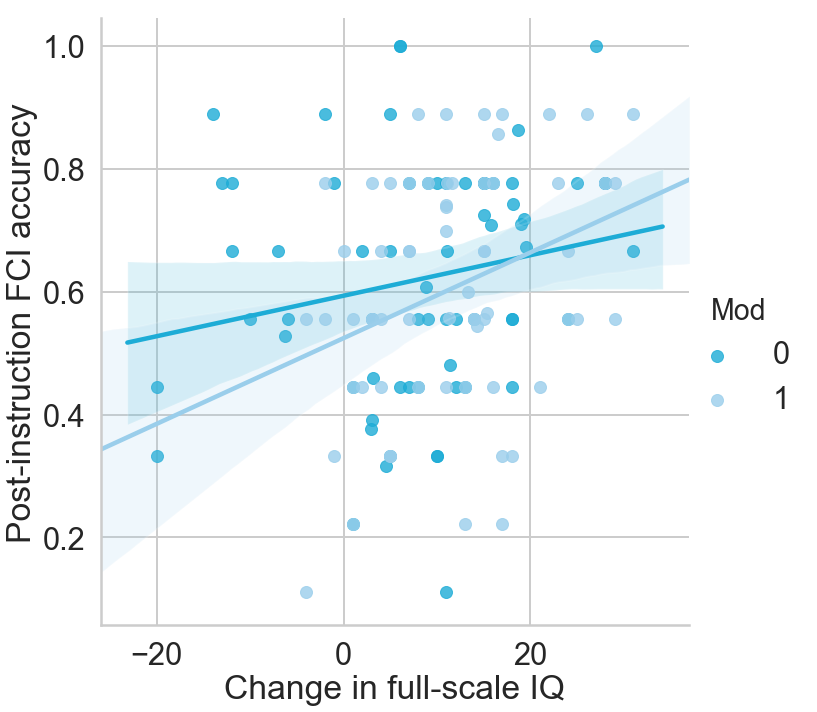

In [65]:
plt.tight_layout(pad=5)
g = sns.lmplot('delta Full Scale IQ', 'Post Mean FCI Accuracy', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10., )
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in full-scale IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_fsiqXpost_fci_acc-m.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

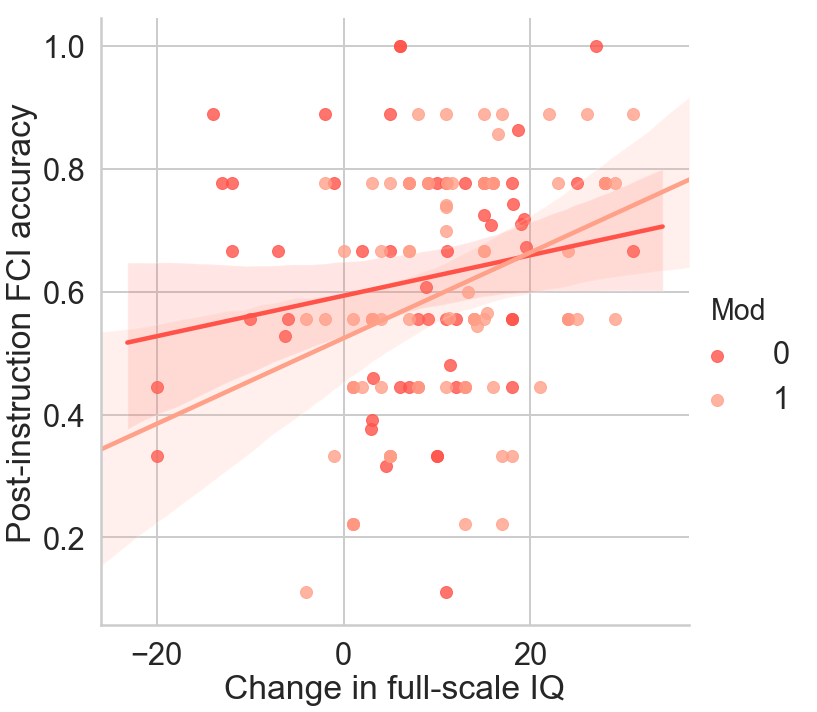

In [66]:
plt.tight_layout(pad=5)
g = sns.lmplot('delta Full Scale IQ', 'Post Mean FCI Accuracy', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in full-scale IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_fsiqXpost_fci_acc-f.png'), dpi=300)

In [67]:
df_f.index.shape

(130,)

In [68]:
df_m.index.shape

(130,)

In [69]:
float(df_m.index.shape[0]) + float(df_f.index.shape[0])

260.0

<Figure size 432x288 with 0 Axes>

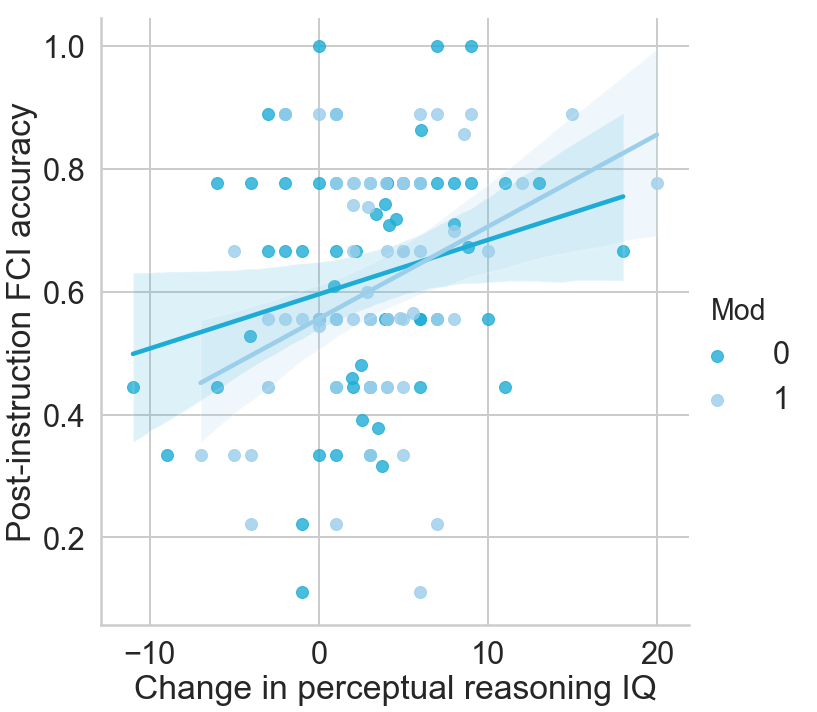

In [70]:
plt.tight_layout(pad=5)
g = sns.lmplot('delta Perceptual Reasoning', 'Post Mean FCI Accuracy', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10., truncate=True)
#g.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
g.set_xlabels('Change in perceptual reasoning IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_priqXpost_fci_acc-m.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

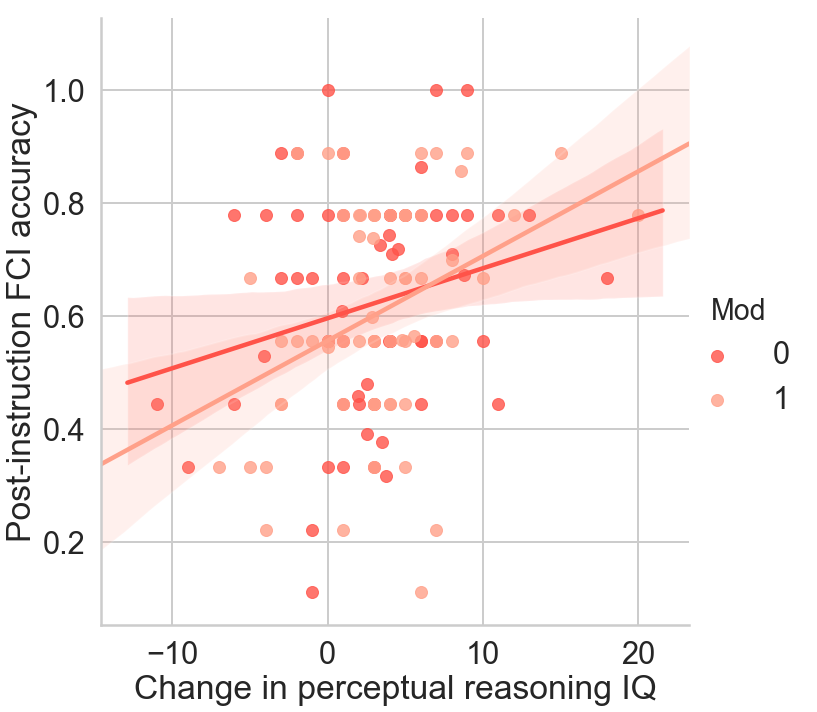

In [71]:
plt.tight_layout(pad=5)
g = sns.lmplot('delta Perceptual Reasoning', 'Post Mean FCI Accuracy', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in perceptual reasoning IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_priqXpost_fci_acc-f.png'), dpi=300)